# Cargamos Datos

In [1]:
import fastai
import torch
from fastai.vision import *
from shutil import copyfile
import os
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

In [2]:
path = '/shared/pytorch-CycleGAN-and-pix2pix/results_TFG/CanRuti_Clinic_NoNormal/CanRuti_Clinic_NoNormal/test_latest/images'


In [3]:
variant = os.listdir('/shared/Datasets_Classification/Classification_CanRuti/VARIANT_LYMPHOCYTE')
atypical = os.listdir('/shared/Datasets_Classification/Classification_CanRuti/ATYPICAL_LYMPHOCYTE')
blast = os.listdir('/shared/Datasets_Classification/Classification_CanRuti/BLAST')

In [4]:
def catcher(x): return re.findall('([a-zA-Z]+_+[\d]+)', x)[0]


In [5]:
variant_png = [catcher(i)+'_fake_B.png' for i in variant]
atypical_png = [catcher(i)+'_fake_B.png' for i in atypical]
blast_png = [catcher(i)+'_fake_B.png' for i in blast]

In [6]:
#or i in variant_png:
#   copyfile(os.path.join(path,i), os.path.join("/shared/Datasets_Classification/CanRuti_Fake_Cyc/VARIANT_LYMPHOCYTE", i))
#   
#or i in blast_png:
#   copyfile(os.path.join(path,i), os.path.join("/shared/Datasets_Classification/CanRuti_Fake_Cyc/BLAST", i))
#   
#or i in atypical_png:
#   copyfile(os.path.join(path,i), os.path.join("/shared/Datasets_Classification/CanRuti_Fake_Cyc/ATYPICAL_LYMPHOCYTE", i))
#   

In [7]:
folder_1 = os.listdir("/shared/Datasets_Classification/CanRuti_Fake_Cyc/ATYPICAL_LYMPHOCYTE")
folder_2 = os.listdir("/shared/Datasets_Classification/CanRuti_Fake_Cyc/VARIANT_LYMPHOCYTE")
folder_3 = os.listdir("/shared/Datasets_Classification/CanRuti_Fake_Cyc/BLAST")
dic_Classif = {
      'ATYPICAL_LYMPHOCYTE':len(folder_1),
      'VARIANT_LYMPHOCYTE':len(folder_2),
      'BLAST':len(folder_3)
     }

pd.DataFrame(dic_Classif, index=['N'])

,ATYPICAL_LYMPHOCYTE,VARIANT_LYMPHOCYTE,BLAST
N,47,57,80


In [8]:
folder_classes = "/shared/Datasets_Classification/CanRuti_Fake_Cyc"
tfms = get_transforms(flip_vert=True, max_warp=None, max_zoom=1.01, max_rotate=120, max_lighting=0.1)


#### Creación del DataBunch de las imágenes de Can Ruti Fake

Aunque haya una separación del 50 por ciento en cada set, solo se utilizará un conjunto de validación para el test, el de training se ignorará

In [9]:
df_train = pd.read_csv('/shared/can_ruti/train.csv')
df_train['x'] = df_train['x'].apply(lambda x: x.replace('.jpg', '_fake_B.png'))
df_train['z'] = False
df_train.head()

,x,y,z
0,BLAST/BL_10600573_fake_B.png,BLAST,False
1,BLAST/BL_13076127_fake_B.png,BLAST,False
2,BLAST/BL_12630836_fake_B.png,BLAST,False
3,BLAST/BL_10600634_fake_B.png,BLAST,False
4,BLAST/BL_12630955_fake_B.png,BLAST,False


In [10]:
df_valid = pd.read_csv('/shared/can_ruti/validation.csv')
df_valid['x'] = df_valid['x'].apply(lambda x: x.replace('.jpg', '_fake_B.png'))
df_valid['z'] = True
df_valid.head()

,x,y,z
0,ATYPICAL_LYMPHOCYTE/LY_13166703_fake_B.png,ATYPICAL_LYMPHOCYTE,True
1,ATYPICAL_LYMPHOCYTE/LY_13103960_fake_B.png,ATYPICAL_LYMPHOCYTE,True
2,BLAST/BL_10600656_fake_B.png,BLAST,True
3,VARIANT_LYMPHOCYTE/LY_13130834_fake_B.png,VARIANT_LYMPHOCYTE,True
4,BLAST/BL_10600719_fake_B.png,BLAST,True


In [11]:
df_split = pd.concat([df_train, df_valid])
df_split = df_split.rename(columns={'x': 'name','y': 'label','z':'is_valid'})
df_split.head()

,name,label,is_valid
0,BLAST/BL_10600573_fake_B.png,BLAST,False
1,BLAST/BL_13076127_fake_B.png,BLAST,False
2,BLAST/BL_12630836_fake_B.png,BLAST,False
3,BLAST/BL_10600634_fake_B.png,BLAST,False
4,BLAST/BL_12630955_fake_B.png,BLAST,False


In [12]:
folder_classes

'/shared/Datasets_Classification/CanRuti_Fake_Cyc'

In [13]:
data = (ImageList.from_df(df_split, folder_classes) #Where to find the data? -> in path and its subfolders
        .split_from_df()         #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .transform(tfms, size=224)       #Data augmentation? -> use tfms with a size of 64
        .databunch(num_workers=0)
        .normalize(imagenet_stats))   

In [14]:
data.batch_size = 20

#### Descripción del Conjunto de datos Can Ruti Fake

In [15]:
pd.DataFrame.from_dict({'Number of classes':[data.c],
'train_size':[len(data.train_ds)],
'valid_size':[len(data.valid_ds)]},
orient = 'index', columns=['N'])

,N
Number of classes,3
train_size,92
valid_size,92


#### Conteo de clases del conjunto de training de datos Can Ruti Fake

train_ds = data.train_ds.to_df()
pd.DataFrame(train_ds['y'].value_counts()).rename(columns={'y':'N'})

#### Conteo de clases del conjunto de validación de datos Can Ruti Fake

valid_ds = data.valid_ds.to_df()
pd.DataFrame(valid_ds['y'].value_counts()).rename(columns={'y':'N'})

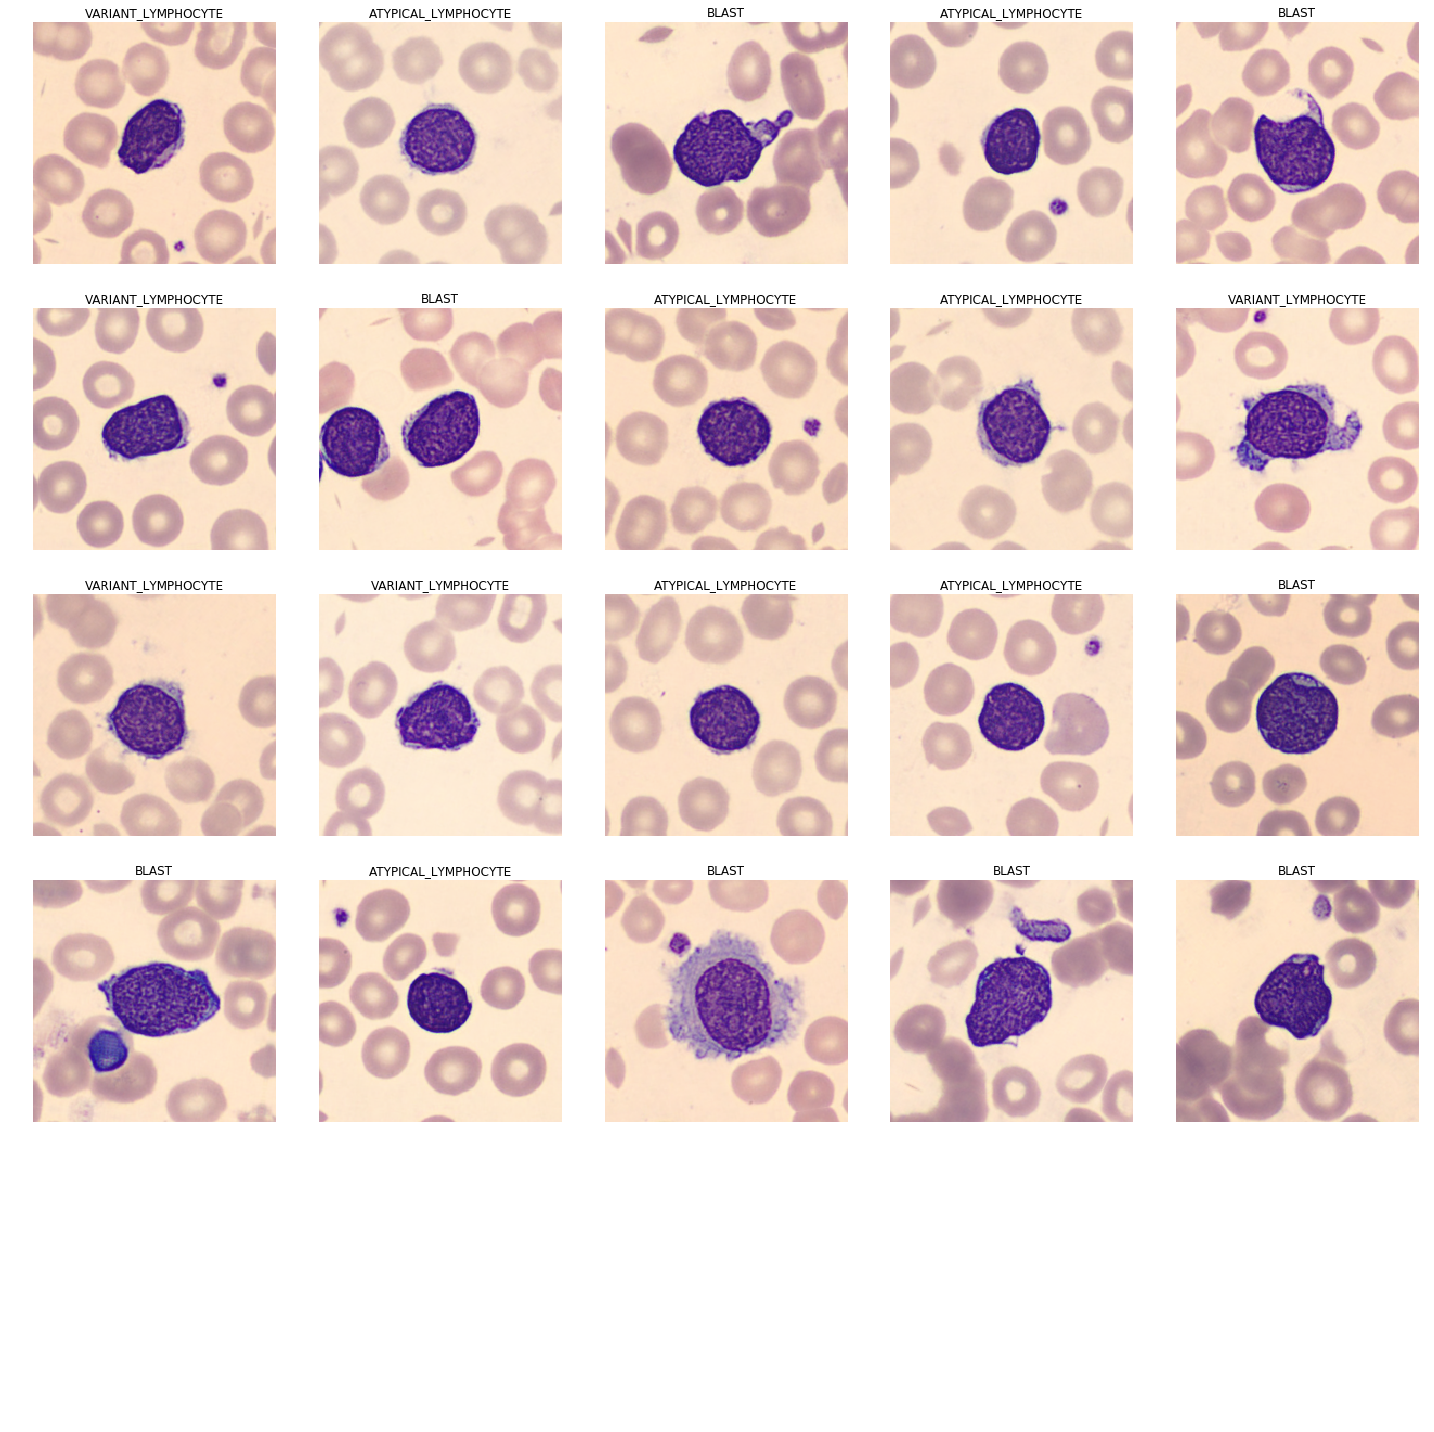

In [16]:
data.show_batch()


# Test Canruti Resnet 18 Focal Loss Preentrenada en Clinic

Se crea un learner con datos auxilares del clinic pero se sustituye con el Databunch de CanRuti anterior para validar en CanRuti. Nótese que se incorporan los pesos del clínic con el método `.load()`

In [16]:
folder_models = "/shared/Datasets_Classification/Classification_Clinic_Balanced"
learn = None
learn = load_learner(folder_models, 'export_stage-2-18-Clinic_Focal_3_Classes')
learn.data = data

Estadísticas de la validación den CanRuti

In [17]:
results = learn.validate(data.valid_dl)

valid_CanRuti = dict(zip(['valid_loss', 'error_rate', 'accuracy'],
                         [results[0], results[1].item(),results[2].item()]))

pd.DataFrame(valid_CanRuti, index = ['metrics'])

,valid_loss,error_rate,accuracy
metrics,3.330515,0.467391,0.532609


In [18]:
plt.rcParams.update({'font.size': 18})

from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import precision_score, recall_score

def multiclass_roc_auc_score(y_test, y_pred, average="micro"):
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

val_preds,val_targets = learn.get_preds() 

y_test = pd.Series(np.array(val_preds.max(1)[1])).map(dict(zip([0,1,2],learn.data.classes)))
y_true = pd.Series(np.array(val_targets)).map(dict(zip([0,1,2],learn.data.classes)))


precision = precision_score(y_test, y_true, average='micro')
recall = recall_score(y_test, y_true, average='micro')

pd.DataFrame({'multiclass_roc_auc_score': multiclass_roc_auc_score(y_test, y_true),
             'precision':precision,
             'recall':recall,
             }, index = ['metrics'])

,multiclass_roc_auc_score,precision,recall
metrics,0.649457,0.532609,0.532609


`Matriz de confusión` de la validación en Can Ruti

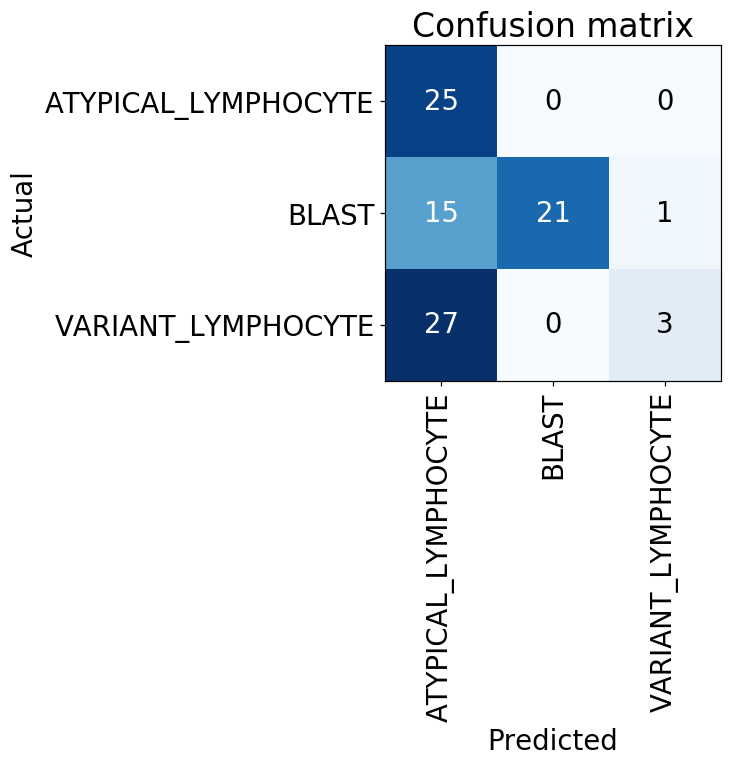

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
losses,idxs = interp.top_losses()
interp.plot_confusion_matrix(figsize=(7,7), dpi=110)




`Matriz de confusión normalizada` de la validación en Can Ruti

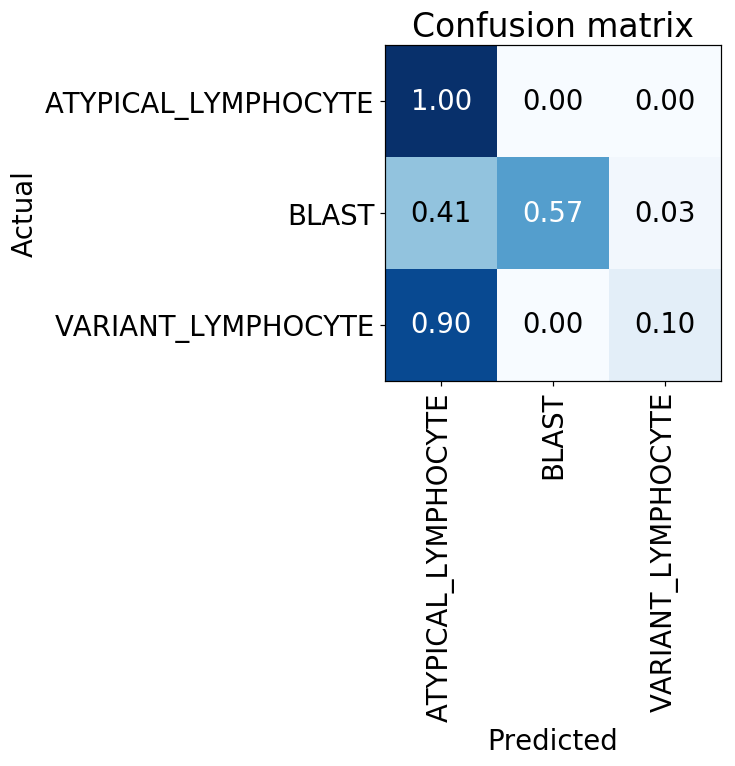

In [25]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=110, normalize=True)

In [21]:
losses,idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True